<center>
    <img width="250" src=timelogo.png />
<h1> Time Series Forecasting
<center>

<hr style="border: dashed rgb(0,1,0) 0.9px"/>

# Theorethical Background

A time series is a series of data points indexed in time order.  Time series are used in *statistics, signal processing, pattern recognition, econometrics, mathematical finance, weather forecasting, earthquake prediction, electroencephalography, control engineering, astronomy, communications engineering,* and largely in any domain of applied science and engineering which involves temporal measurements. **Time series analysis** comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. **Time series forecasting** is the use of a model to predict future values based on previously observed values. Time series are very frequently plotted via line charts.

A stochastic model for a time series will generally reflect the fact that observations close together in time will be more closely related than observations further apart. Models for time series data can have many forms and represent different stochastic processes. When modeling variations in the level of a process, three broad classes of practical importance are the [autoregressive (AR)](https://en.wikipedia.org/wiki/Autoregressive_model) models, the integrated (I) models, and the [moving average (MA)](https://en.wikipedia.org/wiki/Moving-average_model) models. These three classes depend linearly on previous data points.  In particular, fore hte MA model the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term. For AR models, the output variable depends linearly on its own previous values and on a stochastic term.
Combinations of these ideas produce autoregressive moving average (ARMA) and [autoregressive integrated moving average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) models.

Among these models there are some that require the stationarity of the time series while some other they don't. **Stationarity** in a stochastic process is such that parameters such as mean and variance also do not change over time. We will define and explain stationarity for practical purpose in the dedicated section.


The stationarity is striclty related to some typical components of the Time Series:

- **Trend** : Trend is a general direction in which something is developing or changing. So we see an increasing trend in this time series. We can see that the passenger count is increasing with the number of years.

- **Seasonality** :  Another clear pattern can also be seen in the above time series, i.e., the pattern is repeating at regular time interval which is known as the seasonality. Any predictable change or pattern in a time series that recurs or repeats over a specific time period can be said to be seasonality. 



We will use a time series dataset to forecast an output variable analysing four models commonly used in these kind of problem. We will also study the accuracy of each of these models.
The models we will use are:

- Simple Exponential Smoothing (SES)
- Holt-Winter Method
- ARIMA Model

and we will explain each of them in the dedicated sections.

<hr style="border: dashed rgb(0,1,0) 0.9px"/>

# Introduction

The framework is that an investor company is considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help the company in their decision, you need to forecast the traffic on JetRail for the next 7 months. 

The train set contains the number of users per hours for a year.
The test set simply contains the timeseries of data and hours for the next seven months.

The notebook is structured as follows:


- [Introduction](#Introduction)

- [Inizialization](#Inizialization)

- [Exploration of Data](#Exploration) 

- [Stationarity](#Stationarity)

- [Model I: Simple Exponential Smoothing (SES)](#m1)

- [Model II: Holt-Winter Methods](#m2)

- [Model III: ARIMA Model](#m3)

- [Conclusions](#conc)


# Inizialization 

In [1]:
import pandas as pd          
import numpy as np          
import matplotlib.pyplot as plt  
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('https://datahack-prod.s3.amazonaws.com/train_file/Train_SU63ISt.csv')
test=pd.read_csv('https://datahack-prod.s3.amazonaws.com/test_file/Test_0qrQsBZ.csv')

In [3]:
train_original=train.copy() 
test_original=test.copy()

<a id='Exploration'></a>
# Exploration of Data

In [4]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [5]:
train.tail(3)

,ID,Datetime,Count
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [6]:
test.head(3)

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00


In [7]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [8]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [9]:
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']

In [10]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

In [11]:
train.head(3)

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


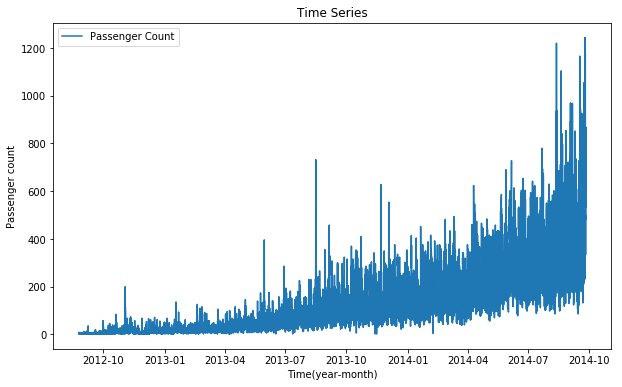

In [12]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(10,6)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

### Hypothesis validation and Data visualization

There will be an increase in the traffic as the years pass by

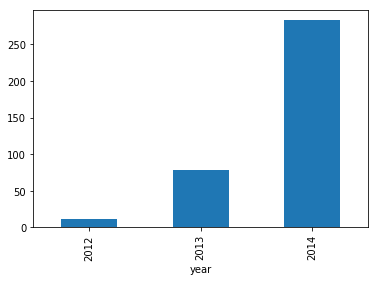

In [13]:
train.groupby('year')['Count'].mean().plot.bar()

The traffic will be high from May to October because tourist visits generally increases during this time perion

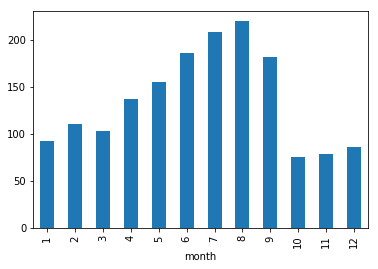

In [14]:
train.groupby('month')['Count'].mean().plot.bar()

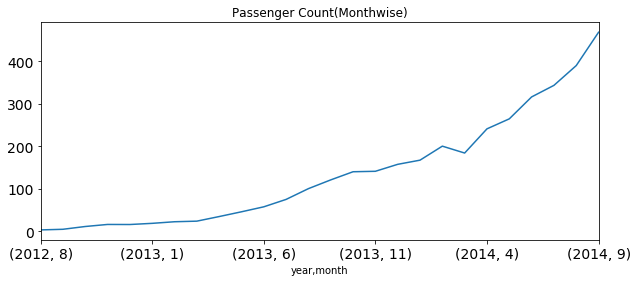

In [15]:
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(10,4), title= 'Passenger Count(Monthwise)', fontsize=14)

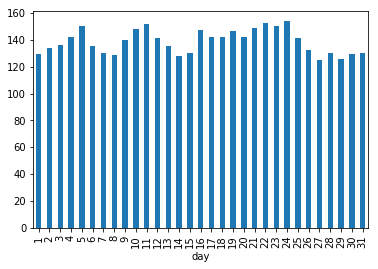

In [16]:
train.groupby('day')['Count'].mean().plot.bar()

Traffic during the peak hours will be high

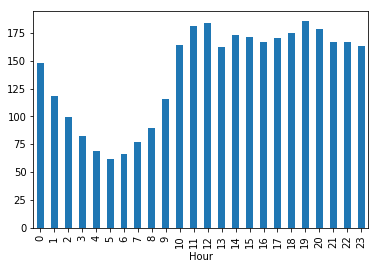

In [17]:
train.groupby('Hour')['Count'].mean().plot.bar()

Traffic on weekdays will be more as compared to weekends/holidays.

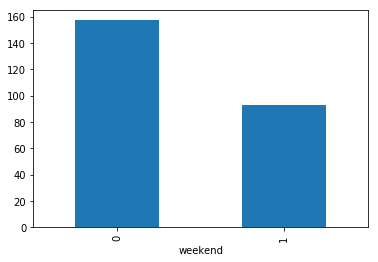

In [18]:
train.groupby('weekend')['Count'].mean().plot.bar()

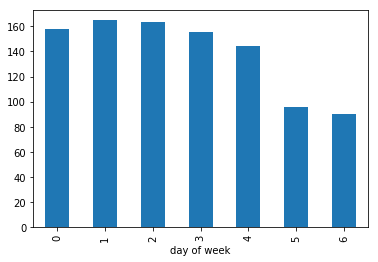

In [19]:
train.groupby('day of week')['Count'].mean().plot.bar()

In [20]:
train=train.drop('ID',1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [22]:
daily.head()

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


In [23]:
hourly.head()

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2,2012,8,25,4,5,1


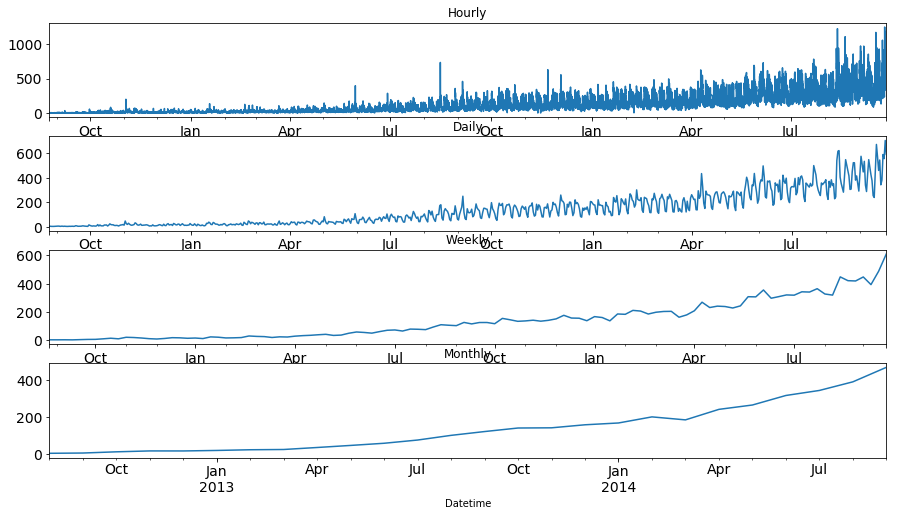

In [24]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

In [25]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

train.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


### Splitting 

In [26]:
Train=train.loc['2012-08-25':'2014-06-24']
valid=train.loc['2014-06-25':'2014-09-25']

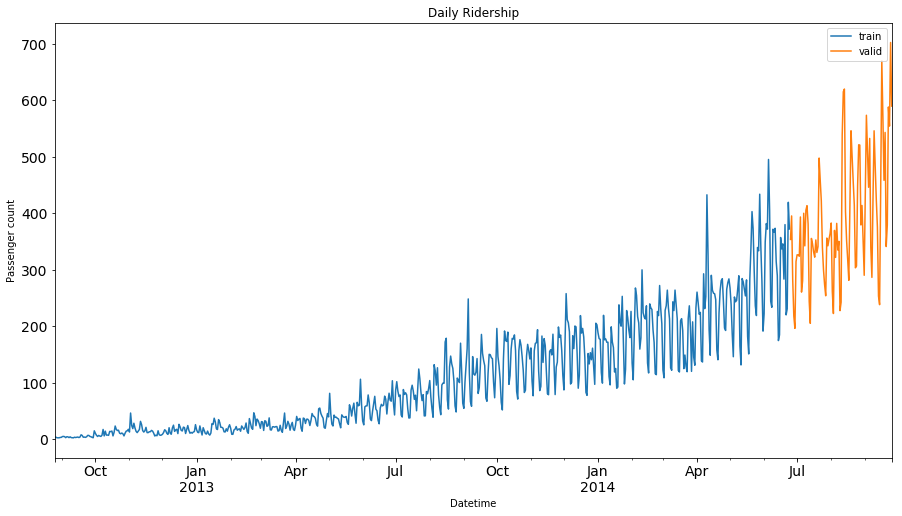

In [27]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

# Stationarity

A TimeSeries is said to be stationary if its statistical properties such as mean, variance remain constant over time. Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- autocovariance that does not depend on time

Even if it's sometime possible look at the stationarity from plots it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:

- **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

- **Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [28]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

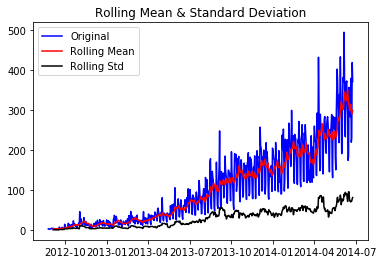

Results of Dickey-Fuller Test:
Test Statistic                   1.387308
p-value                          0.997056
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [29]:
test_stationarity(Train['Count'])

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

## Make the series stationary

Lets understand what is making a timeseries non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
- **Trend**: varying mean over time. In this case we saw that on average, the number of users was growing over time.
- **Seasonality**: variations at specific time-frames. People might have a tendency to use train in a particular day or hours.


The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

- *Transformation*: applying transformation which penalize higher values more than smaller values.
- *Aggregation*: taking average for a time period like monthly/weekly/daily averages
- *Smoothing*: taking rolling averages

In this section we will show the following techniques:

- [Moving Average](#s1)
- [Exponentially weighted moving average](#s2)
- [Differencing](#s3)
- [Decomposing](#s4)

We perform a transformation with a logarithmic function

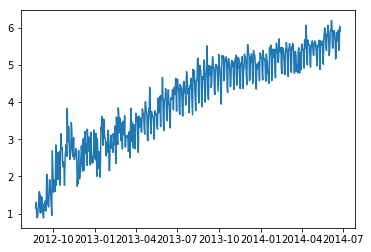

In [30]:
Train_log = np.log(Train.Count)
valid_log=np.log(valid.Count)
plt.plot(Train_log)

<a id='s1'></a>
- ### Moving Average

In [31]:
rol_mean = Train_log.rolling(5).mean()

In [32]:
stat_train_1 = Train_log - rol_mean
stat_train_1.head()

Datetime
2012-08-25         NaN
2012-08-26         NaN
2012-08-27         NaN
2012-08-28         NaN
2012-08-29   -0.123654
Freq: D, Name: Count, dtype: float64

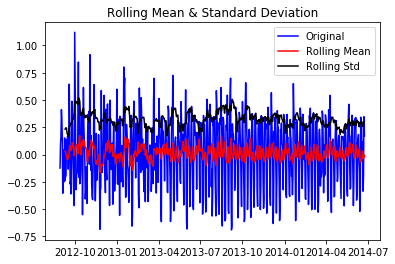

Results of Dickey-Fuller Test:
Test Statistic                -6.691978e+00
p-value                        4.087858e-09
#Lags Used                     2.000000e+01
Number of Observations Used    6.440000e+02
Critical Value (1%)           -3.440545e+00
Critical Value (5%)           -2.866038e+00
Critical Value (10%)          -2.569166e+00
dtype: float64


In [33]:
stat_train_1.dropna(inplace=True)
test_stationarity(stat_train_1)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

<a id='s2'></a>
- ### Exponentially weighted moving average

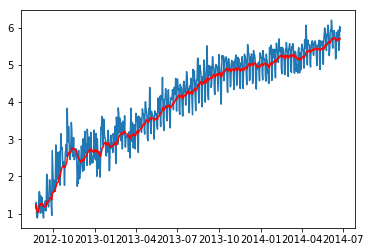

In [34]:
exp_weighted_mean = Train_log.ewm(12).mean()
plt.plot(Train_log)
plt.plot(exp_weighted_mean, color='red')

In [35]:
stat_train_2 = Train_log - exp_weighted_mean

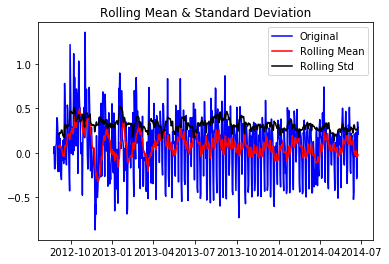

Results of Dickey-Fuller Test:
Test Statistic                  -5.195651
p-value                          0.000009
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [36]:
stat_train_2.dropna(inplace=True)
test_stationarity(stat_train_2)

<a id='s3'></a>
- ### Differencing

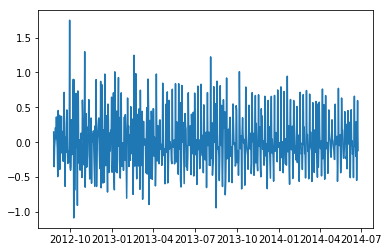

In [37]:
train_log_diff = Train_log - Train_log.shift()
plt.plot(train_log_diff)

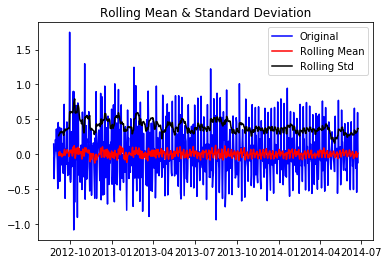

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [38]:
train_log_diff.dropna(inplace=True)
test_stationarity(train_log_diff)

<a id='s4'></a>
- ### Decomposing

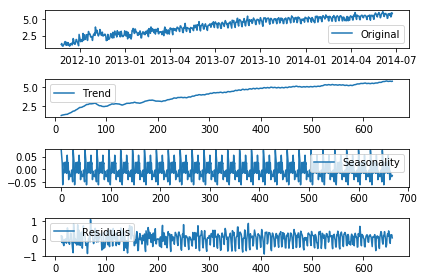

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [40]:
Train_log_decompose = residual
Train_log_decompose.dropna(inplace=True)
test_stationarity(Train_log_decompose)

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

<a id='m1'></a>

## Model I: Simple Exponential Smoothing (SES)

Exponential smoothing is a technique for smoothing time series data where exponential functions are used to assign exponentially decreasing weights over time.
The raw data sequence is often represented by $\{x_t\}$ beginning at time $t=0$ and the output of the exponential smoothing algorithm is commonly written as $\{s_t\}$ which may be regarded as a best estimate of what the next value of $x$ will be. When the sequence of observations begins at time $t=0$, the simplest form of exponential smoothing is given by the formulas:

$$
\begin{align}
s_0&=x_0\\
s_t&=\alpha x_t + (1-\alpha)x_{t-1} + \alpha(1-\alpha)^2x_{t-2}+\cdots
\end{align}
$$

where $0\le\alpha\le 1$ is the the smoothing factor. The two extreme values gives the name of thwo particular method that can be regarded as particular cases of SES:

- $\alpha=0$: Moving Average Method 
- $\alpha=1$: Naive Method 

In general SES is a good choice for forecasting data with no clear trend or seasonal pattern or with dataset timeseries that has been made stationary

In [41]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error 
from math import sqrt 

Text(0.5, 1.0, 'RMSE: 21.6453')

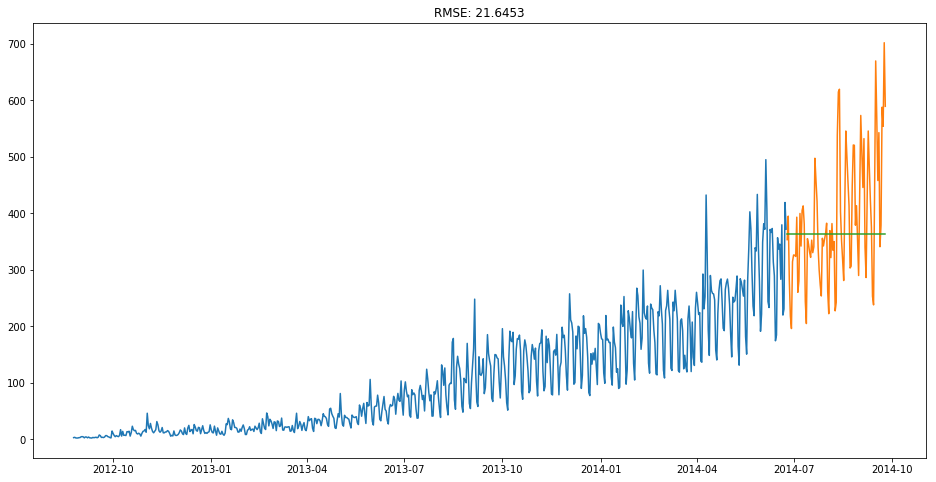

In [155]:
y_hat_avg = valid.copy() 

fit1 = SimpleExpSmoothing(np.asarray(Train.Count)).fit(smoothing_level=0.6,optimized=False)

y_hat_avg['SES'] = fit1.forecast(len(valid)) 


plt.figure(figsize=(16,8))
plt.plot(Train.Count)
plt.plot(valid.Count)
plt.plot(y_hat_avg['SES'])
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-Train.Count)**2)/len(ts)))


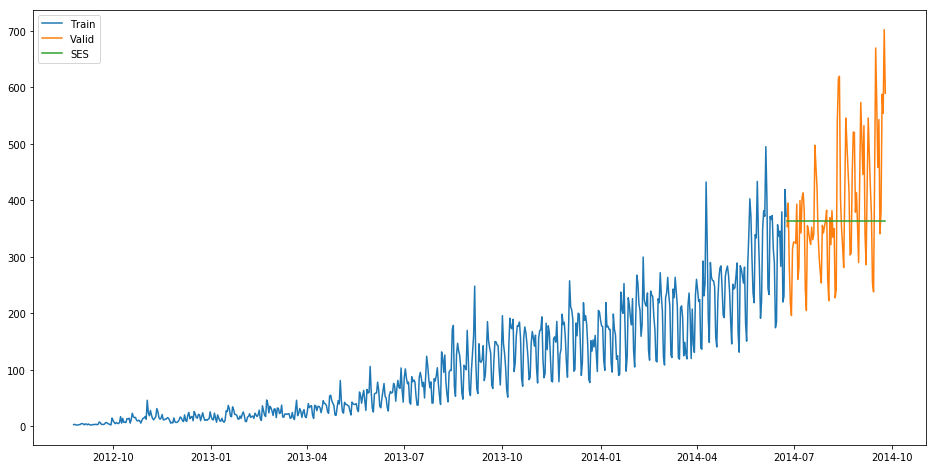

In [167]:
y_hat_avg = valid.copy() 

fit1 = SimpleExpSmoothing(np.asarray(Train.Count)).fit(smoothing_level=0.6,optimized=False)

y_hat_avg['SES'] = fit1.forecast(len(valid)) 



plt.figure(figsize=(16,8)) 
plt.plot(Train.Count, label='Train') 
plt.plot(valid.Count, label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

<a id='m2'></a>

## Model II: Holt-Winter Method

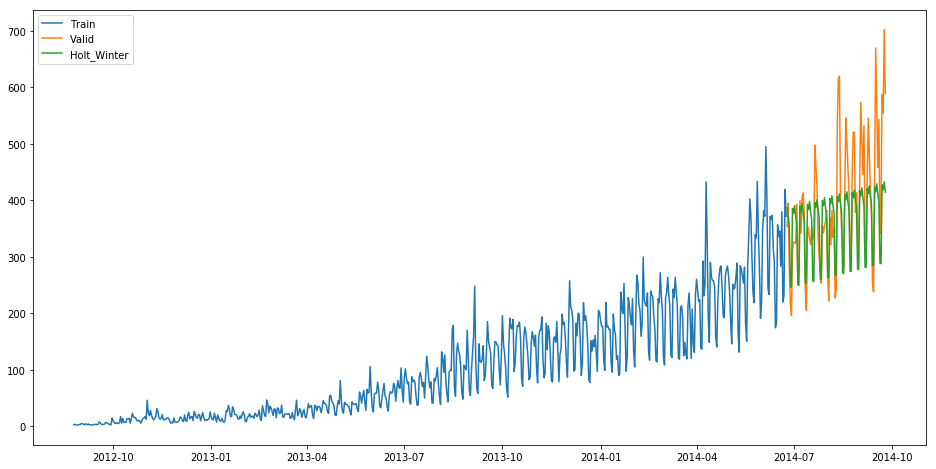

In [200]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']),seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

<a id='m3'></a>
## Model III: ARIMA Model

In [81]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

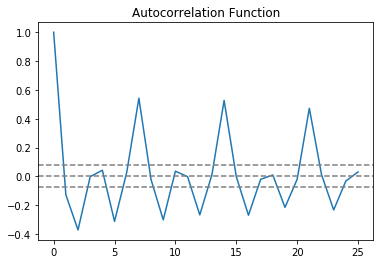

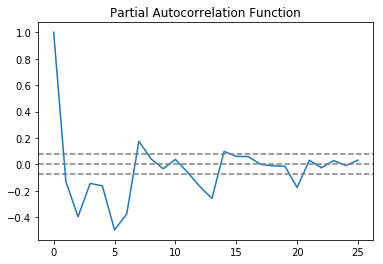

In [82]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function') 
plt.show()

- ### AR Model

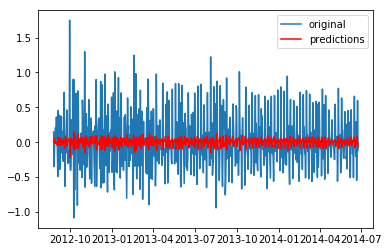

In [83]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(1, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

- ### MA Model

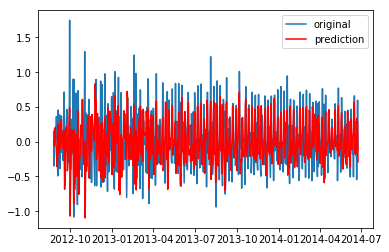

In [85]:
model = ARIMA(Train_log, order=(0, 1, 1))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

- ### Combined ARIMA Model

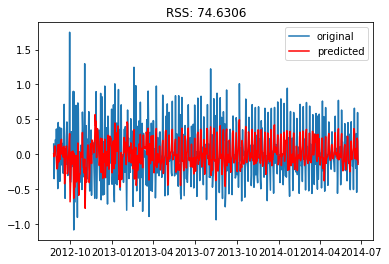

In [110]:
model = ARIMA(Train_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train_log_diff)**2))
plt.legend(loc='best') 
plt.show()

- ### Taking it back to original scale

In [106]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Datetime
2012-08-26    0.006924
2012-08-27   -0.011093
2012-08-28    0.014360
2012-08-29    0.157614
2012-08-30    0.111720
Freq: D, dtype: float64

In [107]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Datetime
2012-08-26    0.006924
2012-08-27   -0.004169
2012-08-28    0.010191
2012-08-29    0.167805
2012-08-30    0.279524
Freq: D, dtype: float64

In [108]:
predictions_ARIMA_log = pd.Series(Train_log.iloc[0], index=Train_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Datetime
2012-08-25    1.152680
2012-08-26    1.159604
2012-08-27    1.148511
2012-08-28    1.162871
2012-08-29    1.320484
Freq: D, dtype: float64

In [137]:
len(predictions_ARIMA),len(train.Count)

(669, 762)

Text(0.5, 1.0, 'RMSE: nan')

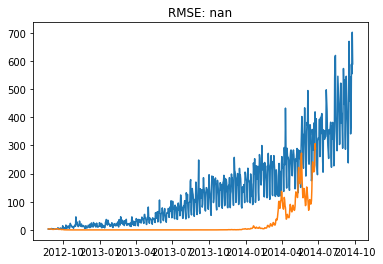

In [109]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(train.Count)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-train.Count)**2)/len(train.Count)))

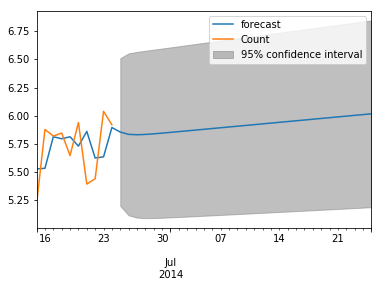

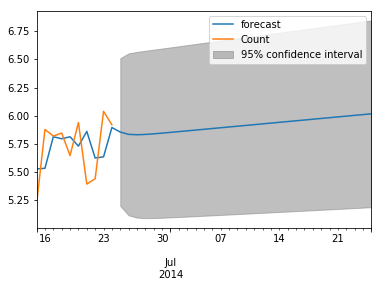

In [145]:
results_ARIMA.plot_predict(start='2014-06-15', end='2014-07-25')

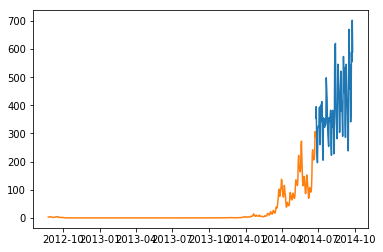

In [152]:
plt.plot(valid.Count)
plt.plot(predictions_ARIMA)